In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv(r"C:\Users\user\OneDrive\Documents\StudentPerformance.csv")

In [3]:
print("Info:")
print(df.info(), "\n")
print("Summary:")
print(df.describe(), "\n")

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None 

Summary:
       Hours Studied  Previous Scores   Sleep Hours  \
count   10000.000000     10000.000000  10000.000000   
mean        4.992900        69.445700      6.530600   
std         2.589309        17.343152      1.695863   
min         1.000000        40.000000      4.000000   
25%         3.000000        

In [4]:
target_score, target_hours = 90, 8
df["distance_to_goal"] = np.sqrt(
    (df["Previous Scores"] - target_score)**2 + (df["Hours Studied"] - target_hours)**2
)
df["performance_angle"] = np.degrees(
    np.arctan2(
        np.abs(df["Previous Scores"] - target_score),
        np.abs(df["Hours Studied"] - target_hours)
    )
)
df["is_high_efficiency"] = (
    (df["Hours Studied"] < 5) & (df["Performance Index"] > 70)
).astype(int)

In [6]:
num_cols = df.select_dtypes(include="number").columns
imp = SimpleImputer(strategy="median")
df[num_cols] = imp.fit_transform(df[num_cols])

In [7]:
if "Extracurricular Activities" in df.columns:
    df = pd.get_dummies(df, columns=["Extracurricular Activities"], drop_first=True)

In [8]:
X = df.drop(columns=["Performance Index"])
y = df["Performance Index"]


In [9]:
rf_fs = RandomForestRegressor(n_estimators=100, random_state=42)
rf_fs.fit(X, y)
importances = pd.Series(rf_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = importances.head(10).index.tolist()
X = X[top_features]


In [10]:
print("Top engineered features:\n", importances.head(10), "\n")

Top engineered features:
 distance_to_goal                    0.783423
Hours Studied                       0.113589
Previous Scores                     0.070917
performance_angle                   0.016828
Sample Question Papers Practiced    0.004963
is_high_efficiency                  0.004523
Sleep Hours                         0.004492
Extracurricular Activities_Yes      0.001265
dtype: float64 



In [ ]:
TASK 2 — Model Comparison & Tuning

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

print("Model performance (baseline):")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name}: R²={r2_score(y_test, y_pred):.3f}, MAE={mean_absolute_error(y_test, y_pred):.3f}")

Model performance (baseline):
LinearRegression: R²=0.989, MAE=1.611
RandomForest: R²=0.986, MAE=1.783
GradientBoosting: R²=0.988, MAE=1.664


In [14]:
print("\nCross-validation (R²):")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    print(f"{name}: mean={scores.mean():.3f}, std={scores.std():.3f}")


Cross-validation (R²):
LinearRegression: mean=0.989, std=0.000
RandomForest: mean=0.986, std=0.000
GradientBoosting: mean=0.988, std=0.000


In [34]:
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10, 30],
    "min_samples_split": [2, 5]
}
gscv = GridSearchCV(RandomForestRegressor(random_state=42),
                    param_grid, cv=4, scoring="r2", n_jobs=-1)
gscv.fit(X_train, y_train)
best_rf = gscv.best_estimator_
print("\nBest RandomForest params:", gscv.best_params_, "\n")


Best RandomForest params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300} 



In [35]:
y_pred_best = best_rf.predict(X_test)
print("Tuned RandomForest results:")
print(f"R²={r2_score(y_test, y_pred_best):.3f}")
print(f"MAE={mean_absolute_error(y_test, y_pred_best):.3f}")
print(f"MSE={mean_squared_error(y_test, y_pred_best):.3f}\n")

Tuned RandomForest results:
R²=0.988
MAE=1.703
MSE=4.588



In [ ]:
TASK 3 — Model Explainability

In [36]:
!pip install shap

In [37]:
import shap

In [38]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

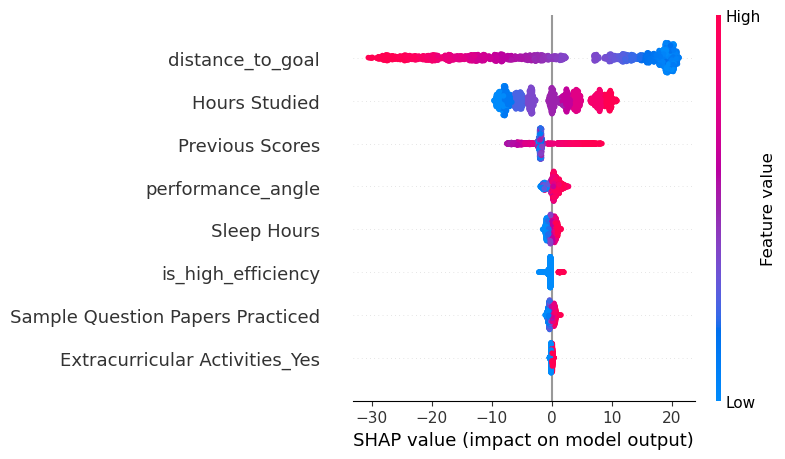

In [39]:
shap.summary_plot(shap_values, X_test)

In [40]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

In [42]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(mean_abs_shap)[-3:]
top_features_shap = X_test.columns[top_idx].tolist()
print("Top-3 SHAP features:", top_features_shap, "\n")

Top-3 SHAP features: ['Previous Scores', 'Hours Studied', 'distance_to_goal'] 



In [ ]:
TASK 4 — Result Visualization & Interpretation

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

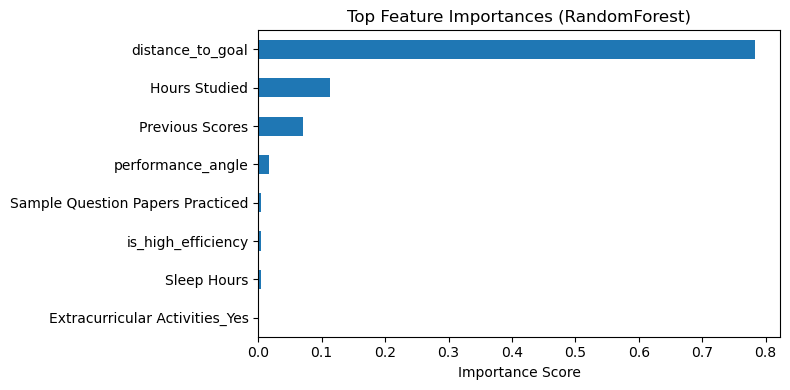

In [20]:
plt.figure(figsize=(8,4))
importances.sort_values(ascending=True).tail(10).plot(kind="barh")
plt.title("Top Feature Importances (RandomForest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

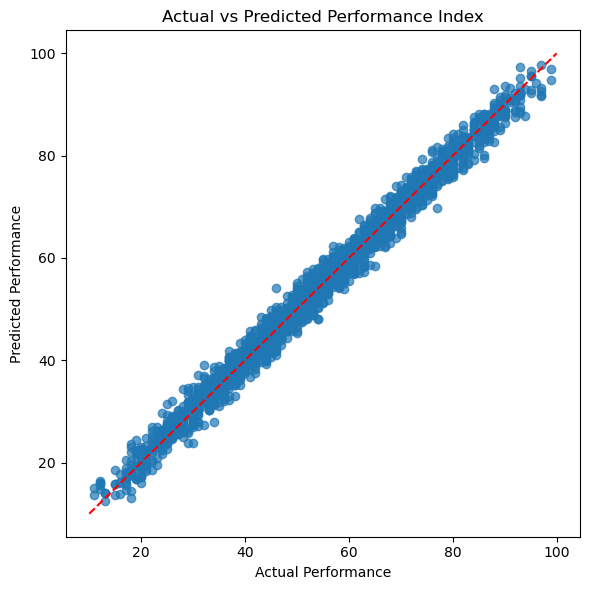

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Actual Performance")
plt.ylabel("Predicted Performance")
plt.title("Actual vs Predicted Performance Index")
plt.tight_layout()
plt.show()

C:\Users\user\anaconda3\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


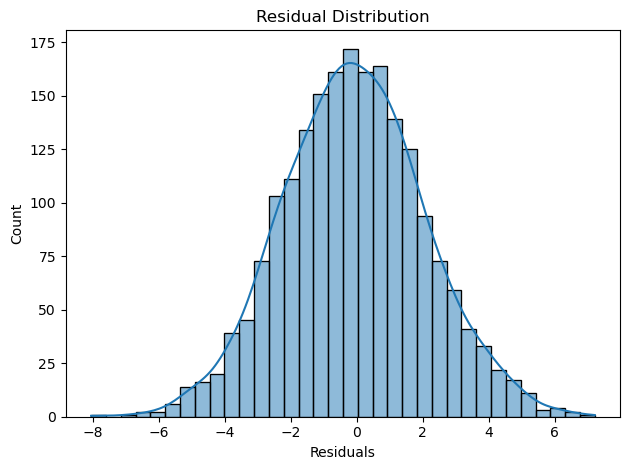

In [22]:
residuals = y_test - y_pred_best
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

In [23]:
print("✅ All tasks completed successfully.")

✅ All tasks completed successfully.


In [47]:
# Save the processed DataFrame
processed_path = "processed_data.csv"
df.to_csv(processed_path, index=False)

print(f"✅ Processed data saved successfully to: {processed_path}")


✅ Processed data saved successfully to: processed_data.csv
